# CNN mushrooms species classification

## Preprocessing base de dades

Carreguem paquests necessaris:

In [1]:
import numpy as np
import pandas as pd
import os
import cv2
import re
import matplotlib.pyplot as plt
from PIL import Image
import pickle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.constraints import maxnorm
from keras.utils import np_utils
from keras.layers.advanced_activations import LeakyReLU
import tensorflow as tf

from numpy import array
from keras.utils import to_categorical
from matplotlib.pyplot import savefig

from sklearn.preprocessing import LabelEncoder

import glob, errno

from keras import models, layers
from keras.models import Sequential
from keras.layers import Conv2D, Dense, MaxPool2D, Dropout, Flatten
from keras.optimizers import Adam
%matplotlib inline

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model 
from tensorflow.keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix
from PIL import Image
import itertools
import os
import shutil
import random
import matplotlib.pyplot as plt

In [4]:
%cd Documents/UNI/TFG

C:\Users\polco\Documents\UNI\TFG


Prova per a carregar una imatge qualsevol i observar-ne el format i les dimensions, per tal de que sigui correcte.

None
RGB
(700, 525)


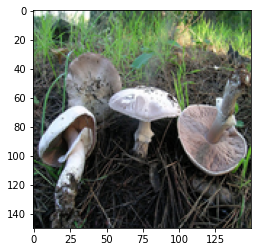

In [5]:
# load the image
image = Image.open('Mushrooms/Agaricus/1.jpg').convert('RGB')
# summarize some details about the image
print(image.format)
print(image.mode)
print(image.size)
image=image.resize((150, 150), Image.ANTIALIAS)
plt.imshow(image)

Com era d'esperar les dimencions de les imatges són extremadament grans, s'hauràn de reduir per tal de poder executar
sense problemes el script.

### Creació de la base de dades

In [6]:
train_path = "Mushrooms_V50_T50/train"
valid_path = "Mushrooms_V50_T50/valid"
test_path = "Mushrooms_V50_T50/test"

In [11]:
train_batches = ImageDataGenerator().flow_from_directory(
directory=train_path,target_size=(150,150),batch_size=32)
valid_batches = ImageDataGenerator().flow_from_directory(
directory=valid_path,target_size=(150,150),batch_size=32)
test_batches = ImageDataGenerator().flow_from_directory(
directory=test_path,target_size=(150,150),batch_size=32,shuffle=False)

Found 8072 images belonging to 12 classes.
Found 600 images belonging to 12 classes.
Found 600 images belonging to 12 classes.


# MODEL ALEXNET

La següent xarxa neuronal convolucional està creada a partir del exemple AlexNet:

In [35]:
keras = tf.keras
model_alex = keras.models.Sequential([
    keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(150,150,3)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(12, activation='softmax')
])
model_alex.compile(optimizer=tf.keras.optimizers.SGD(0.001),
              loss=tf.keras.losses.categorical_crossentropy,
              metrics=['accuracy'])
model_alex.build()
model_alex.summary()

h = model.fit(train_batches, validation_data=valid_batches, epochs=10)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_34 (Conv2D)           (None, 35, 35, 96)        34944     
_________________________________________________________________
batch_normalization_34 (Batc (None, 35, 35, 96)        384       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 17, 17, 96)        0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 17, 17, 256)       614656    
_________________________________________________________________
batch_normalization_35 (Batc (None, 17, 17, 256)       1024      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 8, 8, 384)        

### TEST EVALUATION

19/19 - 31s - loss: 1.2919 - accuracy: 0.6150


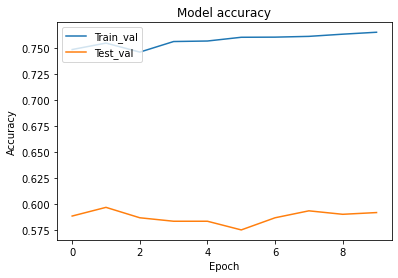

In [36]:
def accuracy_plot(history):
    plt.plot(history.history["accuracy"])
    plt.plot(history.history["val_accuracy"])
    plt.title("Model accuracy")
    plt.ylabel("Accuracy")
    plt.xlabel("Epoch")
    plt.legend(["Train_val", "Test_val"], loc="upper left")
    plt.show()
    
    

test_loss, test_acc = model.evaluate(test_batches, verbose=2)
accuracy_plot(h)

# TRANSFER LEARNING 

### Data augmentation

In [12]:
from tensorflow import keras
from tensorflow.keras import layers

data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

### MODEL

In [20]:
base_model = keras.applications.Xception(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(150, 150, 3),
    include_top=False,
)  # Do not include the ImageNet classifier at the top.

# Freeze the base_model
base_model.trainable = False

# Create new model on top
inputs = keras.Input(shape=(150, 150, 3))
#x = data_augmentation(inputs)  # Apply random data augmentation

# Pre-trained Xception weights requires that input be normalized
# from (0, 255) to a range (-1., +1.), the normalization layer
# does the following, outputs = (inputs - mean) / sqrt(var)

norm_layer = keras.layers.experimental.preprocessing.Normalization()
mean = np.array([127.5] * 3)
var = mean ** 2
# Scale inputs to [-1, +1]
x = norm_layer(inputs)
norm_layer.set_weights([mean, var])


# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)   # Regularize with dropout
outputs = keras.layers.Dense(12, activation = 'softmax')(x)
model = keras.Model(inputs, outputs)

model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 150, 150, 3)]     0         
_________________________________________________________________
normalization_5 (Normalizati (None, 150, 150, 3)       7         
_________________________________________________________________
xception (Functional)        (None, 5, 5, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d_3 ( (None, 2048)              0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 12)                24588     
Total params: 20,886,075
Trainable params: 24,588
Non-trainable params: 20,861,487
__________________________________________

In [24]:
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss="categorical_crossentropy",
    metrics="accuracy",
)


epochs = 15
model.fit(train_batches, epochs=epochs, validation_data=valid_batches)

Epoch 1/15
253/253 [==============================] - 470s 2s/step - loss: 1.7315 - accuracy: 0.4261 - val_loss: 1.3814 - val_accuracy: 0.5400
Epoch 2/15
253/253 [==============================] - 421s 2s/step - loss: 1.2313 - accuracy: 0.5946 - val_loss: 1.3359 - val_accuracy: 0.5683
Epoch 3/15
253/253 [==============================] - 418s 2s/step - loss: 1.1041 - accuracy: 0.6314 - val_loss: 1.3291 - val_accuracy: 0.5583
Epoch 4/15
253/253 [==============================] - 460s 2s/step - loss: 1.0694 - accuracy: 0.6473 - val_loss: 1.2272 - val_accuracy: 0.5900
Epoch 5/15
253/253 [==============================] - 459s 2s/step - loss: 0.9771 - accuracy: 0.6718 - val_loss: 1.3208 - val_accuracy: 0.5533
Epoch 6/15
253/253 [==============================] - 451s 2s/step - loss: 0.9475 - accuracy: 0.6760 - val_loss: 1.2712 - val_accuracy: 0.5883
Epoch 7/15
253/253 [==============================] - 497s 2s/step - loss: 0.8855 - accuracy: 0.7058 - val_loss: 1.2607 - val_accuracy: 0.5933

### TEST VALIDATION

In [26]:
def accuracy_plot(history):
    plt.plot(history.history["accuracy"])
    plt.plot(history.history["val_accuracy"])
    plt.title("Model accuracy")
    plt.ylabel("Accuracy")
    plt.xlabel("Epoch")
    plt.legend(["Train_val", "Test_val"], loc="upper left")
    plt.show()
    
    

test_loss, test_acc = model.evaluate(test_batches, verbose=2)

19/19 - 30s - loss: 1.2393 - accuracy: 0.6050


### Confusion matrix

In [28]:
test_labels = test_batches.classes
predictions = model.predict(x=test_batches,verbose=0)



In [29]:
cm = confusion_matrix(y_true=test_labels,y_pred=predictions.argmax(axis=1))


In [30]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    
    plt.figure(figsize=(15,15))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion matrix, without normalization


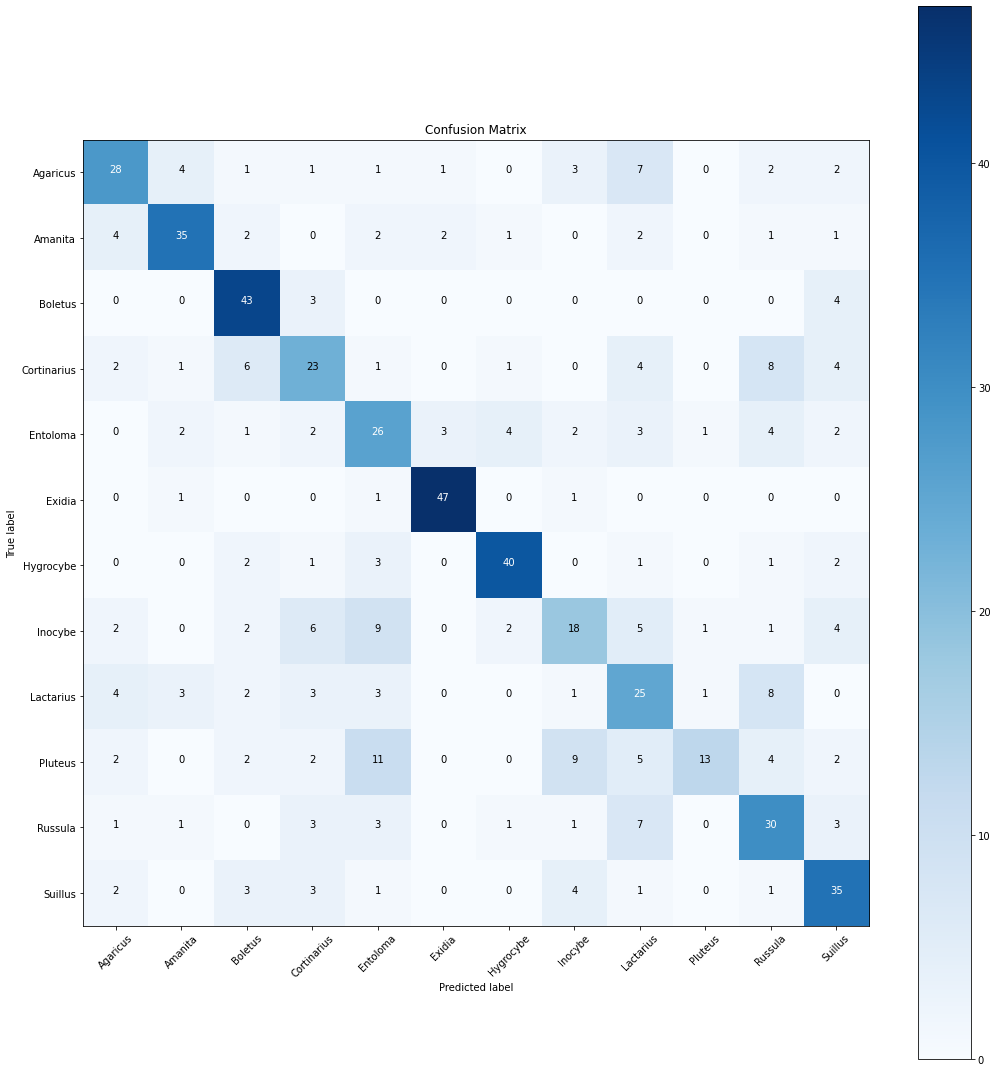

In [31]:
cm_plot_labels=['Agaricus', 'Amanita', 'Boletus', 'Cortinarius', 'Entoloma', 'Exidia', 'Hygrocybe', 'Inocybe', 'Lactarius', 'Pluteus', 'Russula', 'Suillus']
plot_confusion_matrix(cm=cm,classes=cm_plot_labels,title="Confusion Matrix")